In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

Using TensorFlow backend.


In [2]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)
complete_inv_y_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_y.csv')
complete_inv_yhat_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_yhat.csv')
complete_inv_naive_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_naive.csv')
print(complete_inv_y_df.columns)
print(complete_inv_y_df.shape)
print(complete_inv_yhat_df.columns)
print(complete_inv_yhat_df.shape)
print(complete_inv_naive_df.columns)
print(complete_inv_naive_df.shape)

(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'ETHN_D', 'ETHN_E', 'ETHN_H', 'SBP',
       'DBP', 'SBP2', 'DBP2', 'SMOKING', 'EN_

In [4]:
#VIEW_v = VIEW_df.iloc[:, [1,3,4,14,15,16,8,9,10,11,12,13,34,35,36,37,38]].values
#VIEW_sub_df = VIEW_df.iloc[:, [1,3,4,14,15,16,8,9,10,11,12,13,34,35,36,37,38]]
'''
complete_inv_y = complete_inv_y_df.values[:, 1:]
complete_inv_yhat = complete_inv_yhat_df.values[:, 1:]
complete_inv_naive = complete_inv_naive_df.values[:, 1:]
print(VIEW_v.shape)
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)
print(complete_inv_naive.shape)
'''


(2099160, 17)
(571480, 32)
(571480, 32)
(571480, 32)


In [12]:
VIEW_sub_df = VIEW_df.iloc[:, [1,3,4,14,15,16,8,9,10,11,12,13,34,35,36,37,38]]
print(VIEW_sub_df.shape)
VIEW_v = VIEW_sub_df[VIEW_sub_df.iloc[:, 0].isin(np.unique(complete_inv_y[:, 0]))].values
print(VIEW_v.shape)

(2099160, 17)
(571480, 17)


In [5]:
#################################
# data check
# y should match view (ground truth)
#################################
ind_id = complete_inv_y[0, 0]
print(ind_id)
ind_y = complete_inv_y[complete_inv_y[:, 0] == ind_id]
ind_yhat = complete_inv_yhat[complete_inv_yhat[:, 0] == ind_id]
ind_view = VIEW_v[VIEW_v[:, 0] == ind_id]
print(ind_y.shape)
print(ind_yhat.shape)
print(ind_view.shape)
print(np.around(ind_yhat[:, -9:].astype(np.double), decimals=2))
print(np.around(ind_y[:, -9:].astype(np.double), decimals=2))
print(np.around(ind_view[:, [6,7,8,9,10,11]].astype(np.double), decimals=2))

STb77b2NPhNK
(28, 32)
(28, 32)
(28, 17)
[[ 0.    0.    0.    0.    2.18  2.51  0.97  5.16  2.4 ]
 [ 0.    0.    0.    0.    2.18  2.49  1.02  5.14  2.4 ]
 [ 0.    0.    0.    0.    2.17  2.46  1.08  5.13  2.4 ]
 [ 0.    0.    0.    0.    2.17  2.44  1.13  5.12  2.4 ]
 [ 0.    0.    0.    0.    2.16  2.41  1.18  5.11  2.4 ]
 [ 0.    0.    0.    1.    2.16  2.4   1.2   5.1   2.4 ]
 [ 0.    0.    0.    0.    2.16  2.4   1.2   5.1   2.4 ]
 [ 0.    0.    0.    0.    2.16  2.4   1.2   5.1   2.4 ]
 [-0.01 -0.   -0.01  0.13  2.26  2.55  0.84  5.2   2.32]
 [ 0.   -0.    0.   -0.    2.18  2.65  0.89  5.25  2.39]
 [-0.   -0.    0.   -0.    2.18  2.71  0.9   5.31  2.38]
 [ 0.   -0.    0.   -0.    2.15  2.73  0.94  5.32  2.42]
 [ 0.   -0.    0.   -0.    2.15  2.76  0.97  5.36  2.44]
 [ 0.   -0.    0.   -0.    2.16  2.76  0.99  5.38  2.44]
 [ 0.   -0.    0.   -0.    2.19  2.77  1.    5.42  2.43]
 [ 0.   -0.    0.    0.    2.22  2.75  1.01  5.43  2.41]
 [ 0.   -0.    0.    0.    2.21  2.77  1.02  5.4

In [5]:
# Columns of VIEW_v
# STUDENT_INDEX_MASTER, QUARTERS, AGE,
# STATINS, ATORVASTATIN, SIMVASTATIN,
# TEST, HDL, LDL, TRI, TCL, TCHDL,
# TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
#########################
# create naive forecast
#########################
value_indicating_test = max(np.unique(VIEW_v[:, 6]))
value_indicating_no_test = min(np.unique(VIEW_v[:, 6]))

missing_a_measure = 0
IDs_of_missing_measure = []
naive_v = np.empty([0, 17])
for i in range(len(complete_inv_y)//27): 
    ind_id = complete_inv_y[(i*27), 0]
    ind_v = copy.deepcopy(VIEW_v[VIEW_v[:, 0]==ind_id])
    test_list = list(ind_v[0:8, 6])
    quarters_v = copy.deepcopy(ind_v[:, 1])
    age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -11:])
    # parse values from TRUE choleterol lists\
    for j in range(1, 6):
        ch_s = last_v[j+5]
        if len(ch_s) > 4:
            ch_list = ch_s[1:-1].split(', ')
            last_v[j] = float(ch_list[-1])
        else:
            missing_a_measure += 1
            IDs_of_missing_measure.append(ind_v[0, 0])
    ind_v[idx, -11:] = last_v
    last_v[0] = value_indicating_no_test #this might be the wrong assumption
    for j in range((idx+1),28):
        ind_v[j, -11:] = last_v
    ind_v[:, 1] = quarters_v
    ind_v[:, 2] = age_v
    naive_v = np.append(naive_v, ind_v[1:,:], axis = 0)
print("complete_inv_y shape", complete_inv_y.shape)
print("complete_inv_yhat shape", complete_inv_yhat.shape)
print("naive shape", naive_v.shape)

complete_inv_y shape (135000, 32)
complete_inv_yhat shape (135000, 32)
naive shape (135000, 17)


In [7]:
# check to see if data y, yhat and naive are equal
naive_v = complete_inv_naive # naive_v[:, :-5]
print(np.array_equal(complete_inv_y[:, 0], complete_inv_yhat[:, 0]))
print(np.array_equal(complete_inv_y[:, 0], naive_v[:, 0]))
print(naive_v.shape)

True
True
(571480, 32)


In [32]:
#######################################
# Error calculation
#######################################
value_indicating_test = max(np.unique(VIEW_v[:, 6]))
value_indicating_no_test = min(np.unique(VIEW_v[:, 6]))

empty_list_count = 0
empty_list_IDs = []
TCHDL = []
y = []
LSTM = []
naive = []
for i in range(len(complete_inv_y)//28):#len(complete_inv_y)//27
    '''
    ind_id = complete_inv_y[i*27, 0]
    ind_y = copy.deepcopy(complete_inv_y[(i*27):((i+1)*27), :])
    ind_yhat = copy.deepcopy(complete_inv_yhat[(i*27):((i+1)*27), :])
    ind_naive = copy.deepcopy(naive_v[(i*27):((i+1)*27), :])
    ind_truth = copy.deepcopy(VIEW_v[VIEW_v[:, 0] == ind_id])
    ind_truth = ind_truth[1:, :]
    '''
    #print(ind_y.shape)
    #print(ind_yhat.shape)
    #print(ind_naive.shape)
    #print(ind_truth.shape)
    
    ind_id = complete_inv_y[i*28, 0]
    ind_y = copy.deepcopy(complete_inv_y[(i*28):((i+1)*28), :])
    ind_yhat = copy.deepcopy(complete_inv_yhat[(i*28):((i+1)*28), :])
    ind_naive = copy.deepcopy(naive_v[(i*28):((i+1)*28), :])
    ind_truth = copy.deepcopy(VIEW_v[VIEW_v[:, 0] == ind_id])
    #ind_truth = ind_truth[1:, :]
    
    #for j in range(7, 27): # Assess all 20 quarters
    for j in range(27, 28):
        if ind_truth[j, 6] == value_indicating_test:
            if len(ind_truth[j, -1]) > 4:
                #TCHDL_s ind_truth[j, -1][1:-1].split(", ")
                TCHDL_list = [float(TCHDL) for TCHDL in ind_truth[j, -1][1:-1].split(", ")]
                mean_TCHDL = sum(TCHDL_list)/len(TCHDL_list)
                TCHDL.append(mean_TCHDL)
                y.append(ind_y[j, -1])
                LSTM.append(ind_yhat[j, -1])
                naive.append(ind_naive[j, -1])
            else:
                empty_list_count += 1
                empty_list_IDs.append(ind_id)
print(empty_list_count)
print(empty_list_IDs)
print(len(TCHDL))
print(len(y))
print(len(LSTM))
print(len(naive))
              
rmse_y = math.sqrt(mean_squared_error(TCHDL, y))
rmse_yhat = math.sqrt(mean_squared_error(TCHDL, LSTM))
rmse_naive = math.sqrt(mean_squared_error(TCHDL, naive))
print("RMSE y:", rmse_y)
print("RMSE LSTM: ", rmse_yhat)
print("RMSE Naive: ",rmse_naive)           

33
['STmJzBjhcURi', 'STZzTH2VvIHJ', 'STymmYZ1lyjh', 'STI7CGGPXtKo', 'STPCapjU85TX', 'STUk4DcSxrou', 'ST5OJ0Ov5dU2', 'STcbVLDQCbjC', 'STOuyTjSklWI', 'STwM9FifNBiV', 'STK7l3k6VHxD', 'STZSqLu2uSCR', 'STUXL2CNMrQG', 'STGNZaKPWYyo', 'STX3zXVE03tt', 'STz7Ia3vOUDo', 'STqp0t4Q4BUT', 'STh5z5oCGx43', 'STSMEhYw2oiY', 'STvABYVsPYbZ', 'STpjs8yne89m', 'ST23MASErYn3', 'ST7kkfVQObvu', 'STInLbDQV2bt', 'STFybSLdIFXj', 'STs5vUHEnEGC', 'STxDCVApklSt', 'STMCjJIwWwIE', 'STUwtFdrioA4', 'STYBuVduzGQf', 'ST9SKofXoKid', 'STg1S1QBeKAa', 'STqr57XpQUZE']
6639
6639
6639
6639
RMSE y: 0.27214580585103254
RMSE LSTM:  0.8230622091533867
RMSE Naive:  1.0164309763044101


In [218]:
IDs_set = set(empty_list_IDs)
print(len(IDs_set))

121


In [8]:
###############################
#  T test
###############################
# find confidence interval

import scipy.stats as st
'''
true_list_cf = st.t.interval(0.95, len(true_list)-1, 
                              loc=np.mean(true_list), 
                              scale=st.sem(true_list))

import statsmodels.stats.api as sms
true_list_cf = sms.DescrStatsW(true_list).tconfint_mean()
'''

step = len(TCHDL)//10
start = 0
end = start + step
rmse_y_list = [] # interpolated values
rmse_lstm_list = []
#rmse_depmix_list = []
rmse_naive_list = []
for i in range(10):
    rmse_y = math.sqrt(mean_squared_error(TCHDL[start:end], y[start:end]))
    rmse_lstm = math.sqrt(mean_squared_error(TCHDL[start:end], LSTM[start:end]))
    rmse_naive = math.sqrt(mean_squared_error(TCHDL[start:end], naive[start:end]))
    #rmse_depmix2 = sqrt(mean_squared_error(true_list[start:end],forecast_w_q_list[start:end]))
    rmse_y_list.append(rmse_y)
    rmse_lstm_list.append(rmse_lstm)
    rmse_naive_list.append(rmse_naive)
    #rmse_depmix_list2.append(rmse_depmix2)
    start = end
    end = end + step

y_forecast_cf = st.t.interval(0.95, len(rmse_y_list)-1, 
                              loc=np.mean(rmse_y_list), 
                              scale=st.sem(rmse_y_list)) 
lstm_forecast_cf = st.t.interval(0.95, len(rmse_lstm_list)-1, 
                              loc=np.mean(rmse_lstm_list), 
                              scale=st.sem(rmse_lstm_list)) 
naive_forecast_cf = st.t.interval(0.95, len(rmse_naive_list)-1, 
                              loc=np.mean(rmse_naive_list), 
                              scale=st.sem(rmse_naive_list)) 
print(y_forecast_cf)
print(lstm_forecast_cf)
print(naive_forecast_cf)
#print(naive_forecast_cf)
#t test 
print("T test LSTM vs naive")
print(scipy.stats.ttest_ind(rmse_lstm_list, rmse_naive_list))

(0.25840874153447113, 0.34938235260289474)
(0.9592096399932639, 1.0727619952797232)
(0.8917148914318046, 0.9916773036130168)
T test LSTM vs naive
Ttest_indResult(statistic=2.2217267843530273, pvalue=0.039363726964537715)


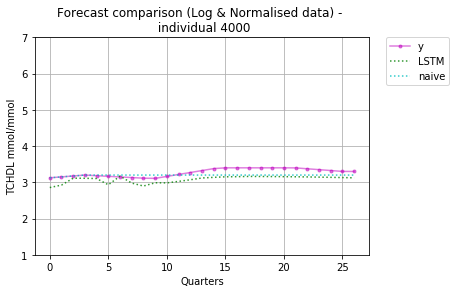

In [230]:
#################################
# plot examples from data
#################################
# sample individual
idx = 4000

ind_y = complete_inv_y[(idx*27):((idx+1)*27), -1]
ind_yhat = complete_inv_yhat[(idx*27):((idx+1)*27), -1]
ind_naive = naive_v[(idx*27):((idx+1)*27), -1]
#ind_id = ind_yhat[0, 0]
quarters = complete_inv_y[(idx*27):((idx+1)*27), 1]
fig, ax = pyplot.subplots()
ax.plot(quarters, ind_y, '.-', color='m', alpha=0.5, label="y")
ax.plot(quarters, ind_yhat, ':', color='g', alpha=0.8, label="LSTM")
ax.plot(quarters, ind_naive, ':', color='c', alpha=0.8, label="naive")
ax.set(xlabel='Quarters',
       ylabel='TCHDL mmol/mmol', 
       Title='Forecast comparison (Log & Normalised data) - \n individual 4000')
ax.set_ylim([1, 7])
ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('/home/whsu014/plots/LSTM_log_normalised_train2500_ind4000.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pyplot.show()

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

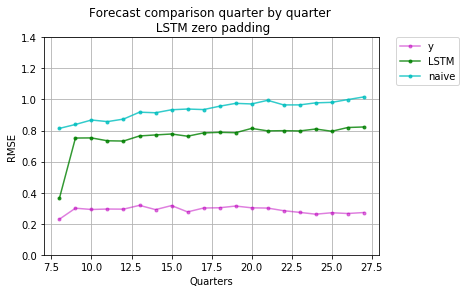

In [35]:
'''
rmse_y = np.array([0.221, 0.319, 0.296, 0.281, 0.297, 0.330, 0.291, 0.309, 
                   0.289, 0.332, 0.302, 0.272, 0.286, 0.278, 0.269, 0.245,
                   0.244, 0.306, 0.534, 0.423])

rmse_lstm = np.array([0.638, 0.734, 0.809, 0.861, 0.952, 1.009, 0.983, 1.010, 
                      1.041, 1.032, 1.116, 1.066, 1.084, 1.083, 1.089, 1.152, 
                      1.111, 1.158, 1.139, 1.293])

rmse_naive = np.array([0.808, 0.859, 0.841, 0.851, 0.883, 0.891, 0.915, 0.923, 
                       0.958, 0.926, 0.989, 0.932, 0.954, 0.998, 0.956, 1.014,
                       0.977, 1.003, 0.983, 1.235])
quarters = np.array([8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])

RMSE y: 0.27214580585103254
RMSE LSTM:  0.8230622091533867
RMSE Naive:  1.0164309763044101
'''

rmse_y = np.array([0.22944313012295398, 0.30005011805923026, 0.29180664792924427,
                   0.2947136776913433, 0.29392653807505864, 0.3183983956664269,
                   0.2908757278339945, 0.3169100790334165, 0.27620343680893317, 
                   0.3012421623046293, 0.3028298911073005, 0.31390363104338764, 
                   0.3024810069660707, 0.3009122631566037, 0.28389573663182827, 
                   0.2731266400401492, 0.2614878348194144, 0.2707344254837927, 
                   0.26586084095480944, 0.27214580585103254])
rmse_lstm = np.array([0.36403706325301455, 0.7518219015248361, 0.7525797247842755,
                      0.7340779905182737, 0.7323918712576748, 0.7652724645307777,
                      0.7717773287252355, 0.7777586315671726, 0.7635494228653397,
                      0.7847580581034923, 0.7884882502584817, 0.7860682855900513, 
                      0.8137957388591446, 0.7979187386273661, 0.7991956714328037,
                      0.7974982408195348, 0.8098464924788059, 0.7954394835260792, 
                      0.8195812648916543, 0.8230622091533867])
rmse_naive = np.array([0.8138445650852526, 0.8391262345020128, 0.8678938367968041,
                       0.8575672434724884, 0.8737655621732114, 0.9183088015098622,
                       0.9145933490639688, 0.9338920603099533, 0.9385448169004719, 
                       0.9350621596302661, 0.9566802563092636, 0.9750666924017455, 
                       0.9713056995361093, 0.9946462848892437, 0.9650569925016395,
                       0.9652276373655632, 0.9783453255992155, 0.9815931274523547,
                       0.9993188423515114, 1.0164309763044101])
quarters = np.array([8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])

fig = pyplot.figure(figsize=(25, 10))
ax = pyplot.figure(figsize=(25, 10))
fig, ax = pyplot.subplots()
ax.plot(quarters, rmse_y, '.-', color='m', alpha=0.5, label="y")
ax.plot(quarters, rmse_lstm, '.-', color='g', alpha=0.8, label="LSTM")
ax.plot(quarters, rmse_naive, '.-', color='c', alpha=0.8, label="naive")
ax.set(xlabel='Quarters',
       ylabel='RMSE', 
       Title='Forecast comparison quarter by quarter \n LSTM zero padding')
ax.set_ylim([0, 1.4])
ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig('/home/whsu014/plots/ForecastQuarterbyQuarterComparison(LSTM zero padding M2M).pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pyplot.show()